In [1]:
import pandas as pd
from sqlalchemy import create_engine

# 데이터베이스 연결 설정
db_host = '192.168.0.41:5432'
db_user = 'postgres'
db_password = '1234'
db_name = 'postgres'

# 데이터베이스 연결
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')

# 데이터베이스에서 데이터 가져오기
query = f"SELECT * FROM finance_data order by name, date"
df_or = pd.read_sql(query, engine)

# 선정된 종목들만 선택
from tqdm import tqdm
df_list = []
for name in tqdm(df_or['name'].unique()):
    df_list.append(df_or[df_or['name']==name])

In [149]:
## ARIMA 이중분류
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# 데이터 불러오기
data = df_list[2].copy()

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

freq = 'D'
# date_index = pd.date_range(start=data.index[0], end=data.index[-1], freq=freq)
# data = data.reindex(date_index)
# data.dropna(inplace=True)
data = data.asfreq(freq)
data = data['close']
# 데이터 분리 (Train/Test)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)



In [150]:
train_data

2019-04-03    53500.0
2019-04-04    54200.0
2019-04-05    55000.0
2019-04-08    55400.0
2019-04-09    55700.0
               ...   
2022-07-22    16200.0
2022-07-25    16150.0
2022-07-26    16200.0
2022-07-27    16200.0
2022-07-28    16100.0
Name: close, Length: 820, dtype: float64

In [151]:
# ARIMA 모델 훈련 및 예측
model = ARIMA(train_data, order=(1, 1, 1))  # ARIMA 모델 생성
model_fit = model.fit()  # 모델 훈련
y_pred = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])  # 테스트 데이터 기간에 해당하는 예측


# # 예측 결과 출력
# print(y_pred)

c:\Users\chocs\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chocs\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chocs\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "pandas\_libs\index.pyx", line 548, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 2273, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1659052800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\chocs\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 516, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas\_libs\index.pyx", line 550, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2022-07-29 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\ch

In [133]:
print(forecast)

804     2927.376536
805     2927.235285
806     2927.243680
807     2927.243181
808     2927.243211
           ...     
1000    2927.243209
1001    2927.243209
1002    2927.243209
1003    2927.243209
1004    2927.243209
Name: predicted_mean, Length: 201, dtype: float64


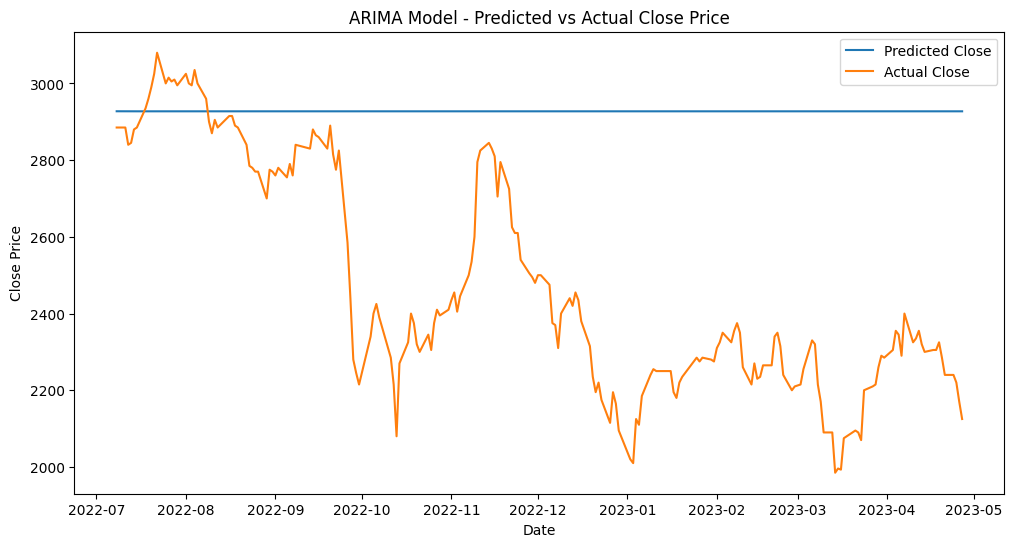

In [134]:
import matplotlib.pyplot as plt

# 예측 결과와 실제 close 가격의 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, forecast, label='Predicted Close')
plt.plot(test_data.index, test_data, label='Actual Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model - Predicted vs Actual Close Price')
plt.legend()
plt.show()

In [103]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


# MAE 계산
mae = mean_absolute_error(test_data, y_pred)
print("MAE:", mae)
# MSE 계산
mse = mean_squared_error(test_data, y_pred)
print("MSE:", mse)
# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)
# MAPE 계산
mape = np.mean(np.abs((test_data - y_pred) / test_data)) * 100
print("MAPE:", mape)
# R-squared 계산
ssr = np.sum((test_data - y_pred) ** 2)  # 회귀식의 잔차 제곱합
sst = np.sum((test_data - np.mean(test_data)) ** 2)  # 총 변동 제곱합
r_squared = 1 - (ssr / sst)
print("R-squared:", r_squared)


MAE: 539.2262745586951
MSE: 386238.4210301041
RMSE: 621.4808291734381
MAPE: 23.549410503620162
R-squared: -3.523558780737459
